In [1]:
import numpy as np
from PIL import Image
import kagglehub
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms.v2 import Compose, ToImage, Normalize, \
Resize, ToPILImage, CenterCrop, RandomResizedCrop, ToDtype
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet
from torchvision import datasets, transforms

# Updated for Torchvision 0.15
from torchvision.models.alexnet import AlexNet_Weights
from torchvision.models import AlexNet_Weights



In [ ]:
# Substitua <dataset-name> pelo nome do dataset desejado
!kaggle datasets download -d  pmigdal/alien-vs-predator-images

# Extraia os dados
!unzip alien-vs-predator-images -d ./data

In [15]:
# Transformações de dados (mais consistentes e aprimoradas)
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),  # Combina redimensionamento e corte, mais eficiente
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), # Menos agressivo
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    "validation": transforms.Compose([
        transforms.Resize(256),  # Mantém o redimensionamento para validação
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

# Carregamento de dados (manipulação de caminhos simplificada)
data_dir = "/content/data/alien_vs_predator_thumbnails/data" # Define o caminho diretamente
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "validation"]} # Compreensão de dicionário
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=(x == "train")) for x in ["train", "validation"]} # Embaralhar apenas para treino
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}


Epoch 1/10
----------
train Loss: 0.6224 Acc: 0.6916
validation Loss: 0.3449 Acc: 0.8350
Epoch 2/10
----------
train Loss: 0.3715 Acc: 0.8444
validation Loss: 0.2539 Acc: 0.8950
Epoch 3/10
----------
train Loss: 0.3328 Acc: 0.8458
validation Loss: 0.3239 Acc: 0.8500
Epoch 4/10
----------
train Loss: 0.3549 Acc: 0.8401
validation Loss: 0.2265 Acc: 0.9100
Epoch 5/10
----------
train Loss: 0.3025 Acc: 0.8646
validation Loss: 0.2196 Acc: 0.9100
Epoch 6/10
----------
train Loss: 0.3020 Acc: 0.8545
validation Loss: 0.2154 Acc: 0.9200
Epoch 7/10
----------
train Loss: 0.2531 Acc: 0.8977
validation Loss: 0.2128 Acc: 0.9250
Epoch 8/10
----------
train Loss: 0.2782 Acc: 0.8876
validation Loss: 0.2112 Acc: 0.9200
Epoch 9/10
----------
train Loss: 0.2720 Acc: 0.8934
validation Loss: 0.2113 Acc: 0.9200
Epoch 10/10
----------
train Loss: 0.2843 Acc: 0.8674
validation Loss: 0.2093 Acc: 0.9250
Melhor Val Acc: 0.9250


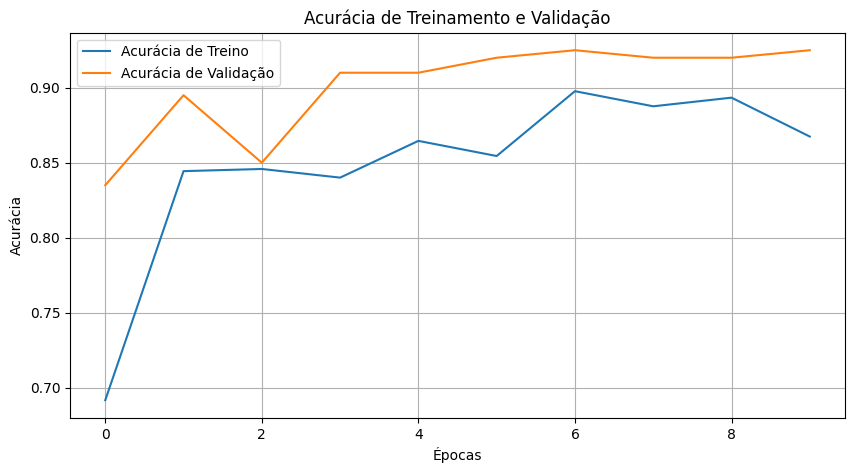

In [22]:
class_names = image_datasets["train"].classes
num_classes = len(class_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregamento e modificação do modelo
model = alexnet(weights=AlexNet_Weights.DEFAULT)

# Congela as features
for param in model.features.parameters():
    param.requires_grad = False

# Modifica o classificador
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(9216, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, num_classes), )

model = model.to(device)

# Perda, otimizador e agendador
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


# Loop de treinamento (aprimorado e mais legível)
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "validation"]: # Nomes de fase simplificados
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), "best_model.pth") # Salva o melhor modelo

            if phase == "train":
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

    print(f"Melhor Val Acc: {best_acc:.4f}")
    model.load_state_dict(torch.load("best_model.pth", weights_only=True)) # Carrega o melhor modelo
    return model, train_acc_history, val_acc_history


# Treina o modelo
model, train_acc, val_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

# Plotagem (aprimorada)
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label="Acurácia de Treino")
plt.plot(val_acc, label="Acurácia de Validação")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.title("Acurácia de Treinamento e Validação")
plt.legend()
plt.grid(True)  # Adiciona grade para melhor legibilidade
plt.show()

Epoch 1/10
----------
train Loss: 0.3748 Acc: 0.8588
validation Loss: 0.2052 Acc: 0.9200
Epoch 2/10
----------
train Loss: 0.2880 Acc: 0.8761
validation Loss: 0.2826 Acc: 0.8750
Epoch 3/10
----------
train Loss: 0.2658 Acc: 0.8876
validation Loss: 0.2874 Acc: 0.8950
Epoch 4/10
----------
train Loss: 0.2300 Acc: 0.9078
validation Loss: 0.1744 Acc: 0.9300
Epoch 5/10
----------
train Loss: 0.1974 Acc: 0.9078
validation Loss: 0.1872 Acc: 0.9400
Epoch 6/10
----------
train Loss: 0.1927 Acc: 0.9179
validation Loss: 0.1904 Acc: 0.9350
Epoch 7/10
----------
train Loss: 0.2032 Acc: 0.9063
validation Loss: 0.1809 Acc: 0.9350
Epoch 8/10
----------
train Loss: 0.2397 Acc: 0.9092
validation Loss: 0.1635 Acc: 0.9350
Epoch 9/10
----------
train Loss: 0.1972 Acc: 0.9150
validation Loss: 0.1754 Acc: 0.9200
Epoch 10/10
----------
train Loss: 0.1625 Acc: 0.9280
validation Loss: 0.1344 Acc: 0.9350
Melhor Val Acc: 0.9400


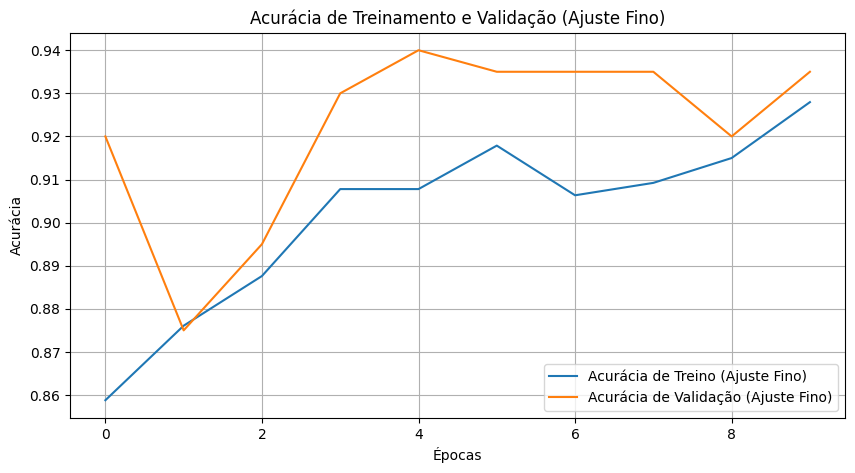

In [24]:
# Ajuste fino (Fine-tuning)
def fine_tune_model(model, criterion, num_epochs=10, lr=1e-5): # Adicione lr como parâmetro
    # 1. Descongelar algumas camadas convolucionais (exemplo: últimas 3)
    for param in model.features[9:].parameters():  # Ajuste o índice conforme necessário
        param.requires_grad = True

    # 2. otimizador
    optimizer = optim.Adam(model.parameters(), lr=3e-4) # Use o lr fornecido

    # 3. Treinar o modelo com as camadas descongeladas
    model_fine_tuning, train_acc_fine, val_acc_fine = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

    return model_fine_tuning, train_acc_fine, val_acc_fine


# Executar o ajuste fino
model_fine_tuning, train_acc_fine, val_acc_fine = fine_tune_model(model, criterion, num_epochs=10, lr=3e-5) # Taxa de aprendizado menor

# Plotar resultados do ajuste fino
plt.figure(figsize=(10, 5))
plt.plot(train_acc_fine, label="Acurácia de Treino (Ajuste Fino)")
plt.plot(val_acc_fine, label="Acurácia de Validação (Ajuste Fino)")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.title("Acurácia de Treinamento e Validação (Ajuste Fino)")
plt.legend()
plt.grid(True)
plt.show()

# Salvar modelo com ajuste fino
torch.save(model_fine_tuning.state_dict(), "alexnet_fine_tuned.pth")